In [17]:
#import related libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from string import punctuation
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
print(stopwords.words('english')[10:15])
from gensim.parsing.preprocessing import remove_stopwords

#import libaries for Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
%matplotlib inline

#import dataset
df = pd.read_csv('/content/finalSentimentdata2.csv')

#get the first 5 rows of the dataset
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
["you've", "you'll", "you'd", 'your', 'yours']


,Unnamed: 0,sentiment,text
0,3204,sad,agree the poor in india are treated badly thei...
1,1431,joy,if only i could have spent the with this cutie...
2,654,joy,will nature conservation remain a priority in ...
3,2530,sad,coronavirus disappearing in italy show this to...
4,2296,sad,uk records lowest daily virus death toll since...


In [18]:
#get the basic insight of the data structure
df.info()

#check if the sentiment categories are biased
df.sentiment.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3090 entries, 0 to 3089
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3090 non-null   int64 
 1   sentiment   3090 non-null   object
 2   text        3090 non-null   object
dtypes: int64(1), object(2)
memory usage: 72.5+ KB


fear     801
sad      795
anger    767
joy      727
Name: sentiment, dtype: int64

In [19]:
#data cleansing
#to transform the text into lowercase and remove special characters 
import re
def clean_text_column(row):
    text = row['text'].lower()
    text = re.sub(r'[^(a-zA-Z\s)]','',text)
    text = re.sub(r'\(','',text)
    text = re.sub(r'\)','',text)
    text = text.replace('\n',' ')
    text = text.strip()
    return text
df['cleaned_text'] = df.apply(clean_text_column,axis = 1)
df

,Unnamed: 0,sentiment,text,cleaned_text
0,3204,sad,agree the poor in india are treated badly thei...,agree the poor in india are treated badly thei...
1,1431,joy,if only i could have spent the with this cutie...,if only i could have spent the with this cutie...
2,654,joy,will nature conservation remain a priority in ...,will nature conservation remain a priority in ...
3,2530,sad,coronavirus disappearing in italy show this to...,coronavirus disappearing in italy show this to...
4,2296,sad,uk records lowest daily virus death toll since...,uk records lowest daily virus death toll since...
...,...,...,...,...
3085,2579,sad,today at 02 30pm a 54 year old bangladeshi mal...,today at pm a year old bangladeshi male admi...
3086,3579,anger,corona virus i implore that you cease activity...,corona virus i implore that you cease activity...
3087,221,joy,issa date once lockdown ends inshaallah (and c...,issa date once lockdown ends inshaallah and co...
3088,2705,sad,the death toll due to covid 19 rose to 31 in j...,the death toll due to covid rose to in jammu...


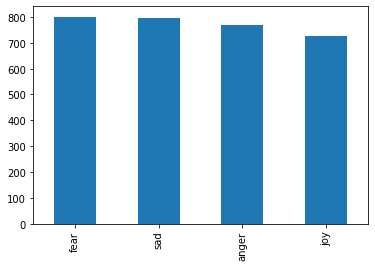

In [20]:
#plot the frequency of each labelled class using bar chart
df.sentiment.value_counts().plot(kind = 'bar')


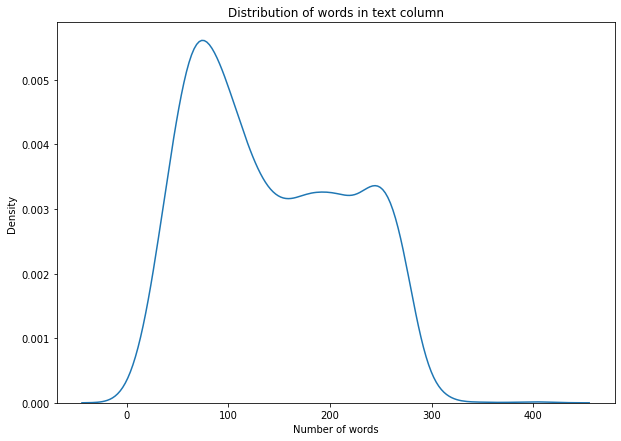

In [22]:
#plot the distribution of words in text column
df["num of words in text"] = df["text"].apply(lambda x:len(x))
plt.figure(figsize=(10,7))
sns.kdeplot(df["num of words in text"])
plt.title("Distribution of words in text column")
plt.xlabel("Number of words")
plt.show()

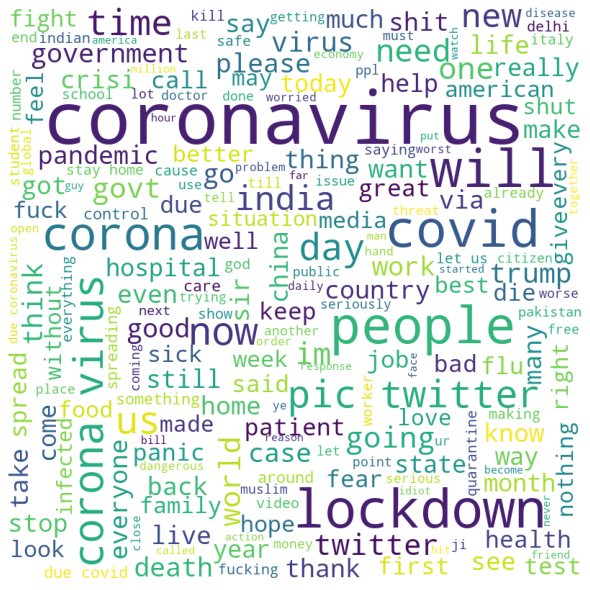

In [21]:
#to visuzalie the important keyword in word cloud
new_string = ''
stopwords = set(list(STOPWORDS))
for val in df.cleaned_text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    new_string += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(new_string) 
  
# plot the WordCloud image to visualize most frequent words                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [23]:
# Creating a mapping for sentiments by using integer

mapping = {'fear':'0', 'sad':'1', 'anger':'2', 'joy':'3' }
df['sentiment'] = df['sentiment'].map(mapping)
df

,Unnamed: 0,sentiment,text,cleaned_text,num of words in text
0,3204,1,agree the poor in india are treated badly thei...,agree the poor in india are treated badly thei...,270
1,1431,3,if only i could have spent the with this cutie...,if only i could have spent the with this cutie...,93
2,654,3,will nature conservation remain a priority in ...,will nature conservation remain a priority in ...,85
3,2530,1,coronavirus disappearing in italy show this to...,coronavirus disappearing in italy show this to...,94
4,2296,1,uk records lowest daily virus death toll since...,uk records lowest daily virus death toll since...,69
...,...,...,...,...,...
3085,2579,1,today at 02 30pm a 54 year old bangladeshi mal...,today at pm a year old bangladeshi male admi...,243
3086,3579,2,corona virus i implore that you cease activity...,corona virus i implore that you cease activity...,101
3087,221,3,issa date once lockdown ends inshaallah (and c...,issa date once lockdown ends inshaallah and co...,66
3088,2705,1,the death toll due to covid 19 rose to 31 in j...,the death toll due to covid rose to in jammu...,277


In [24]:
#to remove stopwords
filtered_sentences = []
for tweet in df.cleaned_text:
    filtered_sentences.append(remove_stopwords(tweet))

filter_sentence_df = pd.DataFrame(filtered_sentences,columns = ['filter_sentence'])

new_twitter_data = pd.concat([df,filter_sentence_df],axis = 1)

new_twitter_data

,Unnamed: 0,sentiment,text,cleaned_text,num of words in text,filter_sentence
0,3204,1,agree the poor in india are treated badly thei...,agree the poor in india are treated badly thei...,270,agree poor india treated badly poors seek livi...
1,1431,3,if only i could have spent the with this cutie...,if only i could have spent the with this cutie...,93,spent cutie vc sakshis n g h coast crossing re...
2,654,3,will nature conservation remain a priority in ...,will nature conservation remain a priority in ...,85,nature conservation remain priority post coron...
3,2530,1,coronavirus disappearing in italy show this to...,coronavirus disappearing in italy show this to...,94,coronavirus disappearing italy intellectuals l...
4,2296,1,uk records lowest daily virus death toll since...,uk records lowest daily virus death toll since...,69,uk records lowest daily virus death toll start...
...,...,...,...,...,...,...
3085,2579,1,today at 02 30pm a 54 year old bangladeshi mal...,today at pm a year old bangladeshi male admi...,243,today pm year old bangladeshi male admitted tr...
3086,3579,2,corona virus i implore that you cease activity...,corona virus i implore that you cease activity...,101,corona virus implore cease activity april st s...
3087,221,3,issa date once lockdown ends inshaallah (and c...,issa date once lockdown ends inshaallah and co...,66,issa date lockdown ends inshaallah corona redh...
3088,2705,1,the death toll due to covid 19 rose to 31 in j...,the death toll due to covid rose to in jammu...,277,death toll covid rose jammu kashmir death repo...


In [25]:
#to split the data into training and test set

msg_train, msg_test, label_train, label_test = train_test_split(new_twitter_data['filter_sentence'],new_twitter_data['sentiment'], test_size=0.1,random_state = 2)

In [26]:
#fitting multinomial Naive Bayes to the training set

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('classifier',MultinomialNB()), 
    ])

pipeline1.fit(msg_train,label_train)
predictions1 = pipeline1.predict(msg_test)
print("Classification report", classification_report(predictions1,label_test), sep="\n")
print("Confusion Matrix", confusion_matrix(predictions1,label_test),sep="\n")

Classification report
              precision    recall  f1-score   support

           0       0.82      0.61      0.70       102
           1       0.86      0.73      0.79       102
           2       0.45      0.78      0.57        46
           3       0.76      0.86      0.81        59

    accuracy                           0.72       309
   macro avg       0.72      0.75      0.72       309
weighted avg       0.77      0.72      0.73       309

Confusion Matrix
[[62  5 34  1]
 [ 6 74  8 14]
 [ 6  3 36  1]
 [ 2  4  2 51]]


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [27]:
#fitting Logistic Regression to the training set

pipeline2 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('classifier',LogisticRegression(solver='sag')), 
    ])

pipeline2.fit(msg_train,label_train)
predictions2 = pipeline2.predict(msg_test)
print("Classification report", classification_report(predictions2,label_test), sep="\n")
print("Confusion Matrix", confusion_matrix(predictions2,label_test),sep="\n")

Classification report
              precision    recall  f1-score   support

           0       0.79      0.66      0.72        91
           1       0.81      0.81      0.81        86
           2       0.59      0.76      0.66        62
           3       0.81      0.77      0.79        70

    accuracy                           0.75       309
   macro avg       0.75      0.75      0.75       309
weighted avg       0.76      0.75      0.75       309

Confusion Matrix
[[60  3 26  2]
 [ 3 70  3 10]
 [10  4 47  1]
 [ 3  9  4 54]]


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [28]:
#fittig Support Vector Machine to the training set
pipeline3 = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stopwords)),
                ('clf', OneVsRestClassifier(SVC(), n_jobs=1)),
            ])

pipeline3.fit(msg_train,label_train)
predictions3 = pipeline3.predict(msg_test)
print("Classification report", classification_report(predictions3,label_test), sep="\n")
print("Confusion Matrix", confusion_matrix(predictions3,label_test),sep="\n")

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Classification report
              precision    recall  f1-score   support

           0       0.78      0.66      0.72        89
           1       0.84      0.80      0.82        90
           2       0.54      0.75      0.63        57
           3       0.84      0.77      0.80        73

    accuracy                           0.74       309
   macro avg       0.75      0.75      0.74       309
weighted avg       0.76      0.74      0.75       309

Confusion Matrix
[[59  2 27  1]
 [ 3 72  5 10]
 [11  3 43  0]
 [ 3  9  5 56]]


In [29]:
#fitting Decision Tree to the training set
pipeline4 = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stopwords)),
                ('clf', DecisionTreeClassifier()),
            ])

pipeline4.fit(msg_train,label_train)
predictions4 = pipeline4.predict(msg_test)
print("Classification report", classification_report(predictions4,label_test), sep="\n")
print("Confusion Matrix", confusion_matrix(predictions4,label_test),sep="\n")


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Classification report
              precision    recall  f1-score   support

           0       0.62      0.56      0.59        84
           1       0.51      0.55      0.53        80
           2       0.50      0.59      0.54        68
           3       0.54      0.47      0.50        77

    accuracy                           0.54       309
   macro avg       0.54      0.54      0.54       309
weighted avg       0.54      0.54      0.54       309

Confusion Matrix
[[47  5 26  6]
 [10 44  5 21]
 [13 11 40  4]
 [ 6 26  9 36]]


In [30]:
#to visualize the accuracy of each algorithms

models = pd.DataFrame({
    'Model': ['Multinomial Naive Bayes', 'Logistic Regression', 'Support Vector Machine', 'Decision Tree'],
    'Test accuracy': [accuracy_score(predictions1,label_test),accuracy_score(predictions2,label_test),accuracy_score(predictions3,label_test),accuracy_score(predictions4,label_test)]})

models.sort_values(by='Test accuracy', ascending=False)


,Model,Test accuracy
1,Logistic Regression,0.747573
2,Support Vector Machine,0.744337
0,Multinomial Naive Bayes,0.721683
3,Decision Tree,0.540453


In [31]:
#prediction of the class by using the algorithms with the highest accuracy score

sentiment_map = {'0':'fear', '1':'sad', '2':'anger', '3':'joy' }

#Test1
review_text1 = ['Life has come to standstill due to this pandemic, millions have lost their job']
predict1 = pipeline1.predict(review_text1)
print("Input Text1: " + str(review_text1))
print("Detected Sentiment: " +sentiment_map.get(predict1[0]))

#Test2
review_text2 = ['COVID is a lie!']
predict2 = pipeline1.predict(review_text2)
print("Input Text2: " + str(review_text2))
print("Detected Sentiment: " +sentiment_map.get(predict2[0]))

#Test2
review_text3 = ['We are getting over with the COVID-19 soon!']
predict3 = pipeline1.predict(review_text3)
print("Input Text3: " + str(review_text3))
print("Detected Sentiment: " +sentiment_map.get(predict3[0]))


Input Text1: ['Life has come to standstill due to this pandemic, millions have lost their job']
Detected Sentiment: sad
Input Text2: ['COVID is a lie!']
Detected Sentiment: anger
Input Text3: ['We are getting over with the COVID-19 soon!']
Detected Sentiment: joy


In [32]:
#prediction of the class by using the algorithms with the lowest accuracy score

sentiment_map = {'0':'fear', '1':'sad', '2':'anger', '3':'joy' }

#Test4
review_text1 = ['Life has come to standstill due to this pandemic, millions have lost their job']
predict4 = pipeline4.predict(review_text1)
print("Input Text1: " + str(review_text1))
print("Detected Sentiment: " +sentiment_map.get(predict4[0]))

#Test5
review_text2 = ['COVID is a lie!']
predict5 = pipeline4.predict(review_text2)
print("Input Text2: " + str(review_text2))
print("Detected Sentiment: " +sentiment_map.get(predict5[0]))

#Test6
review_text3 = ['We are getting over with the COVID-19 soon!']
predict6 = pipeline4.predict(review_text3)
print("Input Text3: " + str(review_text3))
print("Detected Sentiment: " +sentiment_map.get(predict6[0]))


Input Text1: ['Life has come to standstill due to this pandemic, millions have lost their job']
Detected Sentiment: joy
Input Text2: ['COVID is a lie!']
Detected Sentiment: sad
Input Text3: ['We are getting over with the COVID-19 soon!']
Detected Sentiment: joy
